### Import libraries

In [32]:
import random

from pathlib import Path

import numpy as np
import pandas as pd

import networkx as nx

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.nn import Linear

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Fix Seeds

In [33]:
seed = 42
random.seed(seed)   
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')  

DIR_PATH = Path.cwd().parent
DATA_BASE = DIR_PATH / 'data/converted/'
BALANCED_PATH = DATA_BASE / 'balanced'
UNBALANCED_PATH = DATA_BASE / 'unbalanced'

Device: cuda


### Read the data

In [35]:
def load_data(path: Path):
    """Load adjacency matrices from .npy file and data from .csv file
    Args:
        path (str): path to the folder containing adjacency matrices and data
    Returns:
        adj_matrices (np.ndarray): loaded adjacency matrices
        data (pd.DataFrame): loaded data
    """
    # Load adjacency matrices
    A = np.load(f'{path}/Adj_mtrx.npy')
    
    # Load data
    data = pd.read_csv(f'{path}/data.csv')
    
    # Convert data to numpy array
    return A, data

In [36]:
# load the adjacency matrices and the data
A, data = load_data(BALANCED_PATH)  

# Print information about the dataset
S, N = A.shape[0], A.shape[1]
print(f'Number of graphs: {S}')
print(f'Number of nodes: {N}')
display(data.head(5))

# store features in x (S, N, F) and labels in y (S, 1) 
x, y = np.expand_dims(data.iloc[:, 3:].values, axis=-1), np.expand_dims(data.iloc[:,2].values, axis=-1)
F = x.shape[-1]
print(f'Number of features per node: {F}')

Number of graphs: 500
Number of nodes: 20


,pat_id,conf,class,Prot1,Prot2,Prot3,Prot4,Prot5,Prot6,Prot7,...,Prot11,Prot12,Prot13,Prot14,Prot15,Prot16,Prot17,Prot18,Prot19,Prot20
0,1,0.165192,0,-0.288741,1.320418,1.246890,-0.587912,0.425350,1.433823,1.573993,...,1.338356,0.151599,1.333244,-0.893175,-0.736581,2.830105,-0.793974,-1.773393,2.129005,-0.543475
1,2,-0.513246,1,-0.973010,-0.083804,0.434048,1.785993,-1.266904,2.235005,0.844811,...,1.813073,0.427323,0.572022,0.844917,-1.381314,2.000934,0.857619,-4.184703,0.913778,-1.655555
2,3,-0.374802,1,-1.825425,1.211511,2.546314,0.161956,0.211815,4.396854,3.311472,...,-0.204465,-0.150981,1.128062,-0.049212,0.592243,-0.475274,-0.234234,-3.083168,3.457820,-1.471739
3,4,0.367808,1,0.449866,-0.493820,0.975631,1.253092,-1.101147,0.124996,1.165723,...,1.835069,-0.124808,1.011982,-0.066768,0.606598,4.985515,-0.124784,-1.378635,-0.934949,-1.366920
4,5,0.364785,1,-2.554269,-1.272309,0.446490,-1.364757,-0.525800,2.681961,0.755660,...,0.654083,-1.208418,1.341746,0.965073,0.798658,0.568156,2.077395,-2.634093,0.937716,0.327697


Number of features per node: 1


### EDA

In [37]:
def get_avg_degree_centrality(A: np.array) -> np.float64:
  """
    Calculate the average degree centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.degree_centrality(nx.from_numpy_array(A))).values()))

def get_avg_closeness_centrality(A: np.array) -> np.float64:
  """
    Calculate the average closeness centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.closeness_centrality(nx.from_numpy_array(A))).values()))

def get_avg_betweenness_centrality(A: np.array) -> np.float64:
  """
    Calculate the average betweenness centrality of an adjacency matrix.
  """
  return np.mean(list(dict(nx.betweenness_centrality(nx.from_numpy_array(A))).values()))

In [38]:
def histogram_classes(positive, negative, metric, ax, **kwargs):
    # Plot the histogram for positive and negative degrees
    sns.set(style="whitegrid")
    plt.figure(figsize=(5, 5))
    sns.histplot(positive, color="skyblue", label="Positive", ax=ax, **kwargs)
    sns.histplot(negative, color="salmon", label="Negative", ax=ax, **kwargs)
    ax.set_title(f"Average {metric}")
    ax.set_xlabel(f"Average {metric}")
    ax.set_ylabel("Frequency")
    ax.grid(linestyle=':')
    ax.legend()

All connected: True


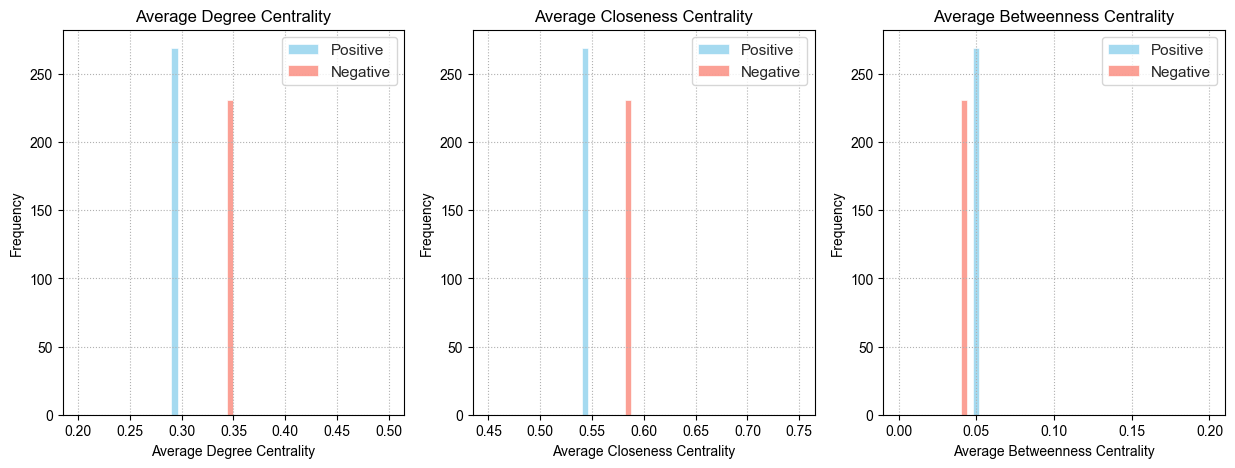

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [39]:
# Check if every graph is connected
print(f'All connected: {all(nx.is_connected(nx.from_numpy_array(G)) for G in A)}')

# Store the adjacency matrices for each of the classes
A_pos = A[np.where(y==0)[0]]
A_neg = A[np.where(y==1)[0]]

# Compute average degree centrality for each sample per class
deg_pos_mean = [get_avg_degree_centrality(a) for a in A_pos]
deg_neg_mean = [get_avg_degree_centrality(a) for a in A_neg]

# Compute average closeness centrality for each sample per class
cls_pos_mean = [get_avg_closeness_centrality(a) for a in A_pos]
cls_neg_mean = [get_avg_closeness_centrality(a) for a in A_neg]

# Compute average betweenness centrality for each sample per class
btw_pos_mean = [get_avg_betweenness_centrality(a) for a in A_pos]
btw_neg_mean = [get_avg_betweenness_centrality(a) for a in A_neg]


# Combine data and metrics into lists
pos_data = [deg_pos_mean, cls_pos_mean, btw_pos_mean]
neg_data = [deg_neg_mean, cls_neg_mean, btw_neg_mean]
metrics = ['Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality']
binranges = [(0.2, 0.5), (0.45, 0.75), (0, 0.2)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Iterate over the data and metrics to create each subplot
for i, (pos, neg, metric, binrange) in enumerate(zip(pos_data, neg_data, metrics, binranges)):
        histogram_classes(pos, neg, metric, ax=axes[i], bins=50, binrange=binrange)  
plt.tight_layout()
plt.show()

Apparently, we can already differentiate between positive and negative based on just the graph structure. **A perfect classifier just using a threshold**, do we even need any GNNs after this? We will further analyze the node features to see if there is a similar way to distinguish between the classes and apply some SOTA GNN models.

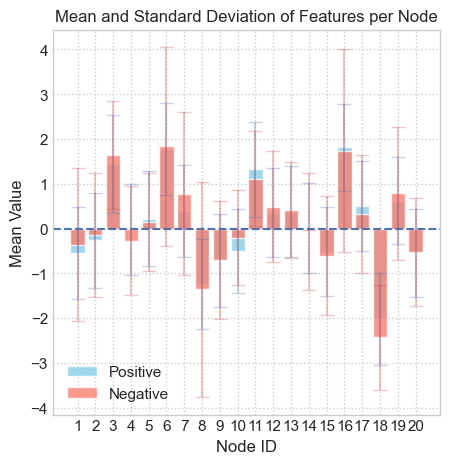

In [40]:
# plot the bars of mean and with std values

x_pos = x[np.where(y==0)[0]]
x_pos_mean = x_pos.mean(axis=0).squeeze()
x_pos_std = x_pos.std(axis=0).squeeze()

x_neg = x[np.where(y==1)[0]]
x_neg_mean = x_neg.mean(axis=0).squeeze()
x_neg_std = x_neg.std(axis=0).squeeze()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5, 5))
plt.bar(range(1, x_pos_mean.shape[0]+1), x_pos_mean, color='skyblue', alpha=0.8, label='Positive', 
        yerr=x_pos_std, error_kw={'alpha': 0.3, 'capsize': 5, 'ecolor': 'b'})
plt.bar(range(1, x_neg_mean.shape[0]+1), x_neg_mean, color='salmon', alpha=0.8, label='Negative',
        yerr=x_neg_std, error_kw={'alpha': 0.3, 'capsize': 5, 'ecolor': 'r'})
plt.axhline(y=0, color='b', linestyle='--')
plt.xticks(range(1, x_pos_mean.shape[0]+1))
plt.grid(linestyle=':')
plt.title('Mean and Standard Deviation of Features per Node')
plt.xlabel('Node ID')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

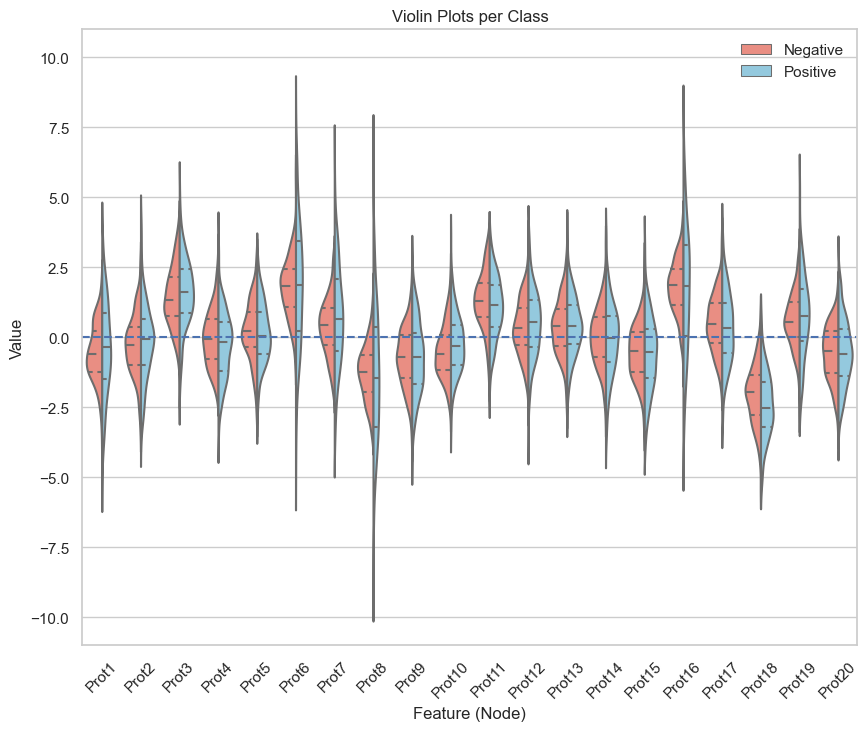

In [41]:
# Plot the violin plot of the features
df_melted = pd.melt(data, id_vars=['class'], 
                    value_vars=[f'Prot{i}' for i in range(1, 21)], 
                    var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                   
sns.set(style="whitegrid")
palette = {1: 'skyblue', 0: 'salmon'}
plt.figure(figsize=(10, 8))
ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted, split=True, inner="quart", palette=palette)
ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
plt.axhline(y=0, color='b', linestyle='--')
plt.title('Violin Plots per Class')
plt.xlabel('Feature (Node)')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.ylim([-11, 11])
plt.show()

<AxesSubplot: >

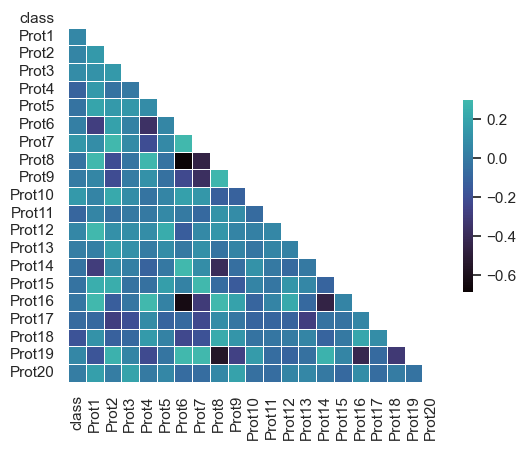

In [42]:
# Plot the correlation between the features
corr = data.iloc[:, 2:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(6, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, vmax=.3, center=0, cmap='mako',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The features seem to have a Gaussian distribution. They do not provide a strong correlation with the **class** target, although some features, such as **Prot18**, **Prot11** seem to be more correlated, which is confirmed by the violin plats, which show a small difference in the mean values per class.

Graph 3


Text(0.5, 1.0, 'Positive class, sample 2')

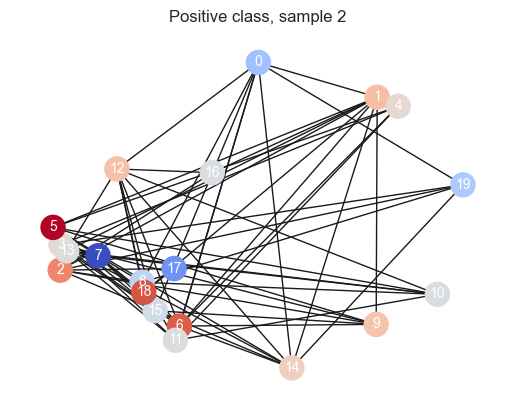

In [43]:
# Visualize one graph and color the nodes according to the feature values
idx = 2

print(f'Graph {idx+1}')
G=nx.from_numpy_array(A[idx])

plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 #pos=nx.circular_layout(G), 
                 pos=nx.spring_layout(G, seed=seed),
                 node_size=300,
                 cmap='coolwarm',
                 font_size=10,
                 font_color='white',
                 node_color=x[idx],
                 )
label = 'Positive' if y[idx]==1 else 'Negative'
plt.title(f'{label} class, sample {idx}')

In [44]:
def plot_graphs(x: np.array, y: np.array, num_graphs: int, class_name: str) -> None:
    """
    Plots the first `num_graphs` graphs from the dataset, with each graph's nodes
    colored according to the feature values.
    """
    class_id = 1 if class_name == 'Positive' else 0 # Use value to get indexes of the respective class
    ids = np.where(y==class_id)[0]
    
    num_rows = num_graphs**0.5
    assert num_rows.is_integer(), 'num_graphs should be a square' # for convenience 
    
    fig, axs = plt.subplots(int(num_rows), int(num_rows))
    fig.suptitle(f'{class_name} class')

    for i, idx in enumerate(ids[-num_graphs:]):
        # Plot graph
        if num_graphs == 1: # If we plot one graph only, we have one object
            ix = i
            ax = axs
        else: # else many objects
            ix = np.unravel_index(i, axs.shape)
            ax = axs[ix]
            
        ax.axis('off')
        G = nx.from_numpy_array(A[idx])
        nx.draw_networkx(G,
                        #pos=nx.circular_layout(G), 
                        pos=nx.spring_layout(G, seed=seed),
                        with_labels=True,
                        cmap='coolwarm',
                        node_size=15,
                        font_size=8,
                        node_color=x[idx],
                        ax=ax,
                        width=0.2
                        )
        

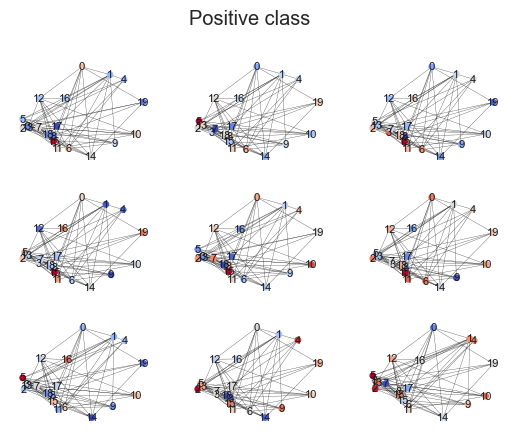

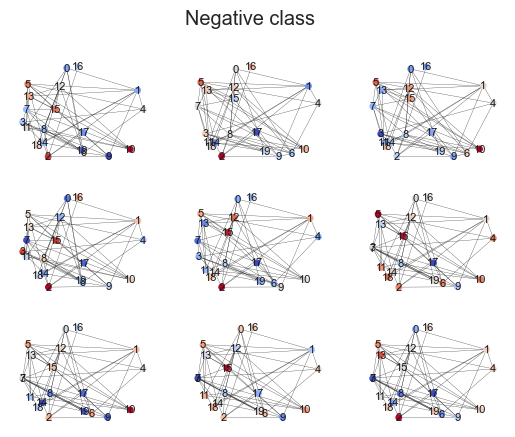

In [45]:
# Plot a few graphs of both classes together
plot_graphs(x, y, 9, 'Positive')
plot_graphs(x, y, 9, 'Negative')

## Data Preprocessing

In [46]:
# Split the data into train, validation, and test sets
id_train, id_test_ = train_test_split(np.arange(len(x)), test_size=0.3, stratify=y, random_state=seed, shuffle=True)
id_val, id_test = train_test_split(np.arange(len(id_test_)), test_size=0.5, stratify=y[id_test_], random_state=seed, shuffle=True)

x_train, y_train, A_train = x[id_train], y[id_train], A[id_train]
x_val, y_val, A_val = x[id_val], y[id_val], A[id_val]
x_test, y_test, A_test = x[id_test], y[id_test], A[id_test]

print(f"Number of samples: Training {x_train.shape[0]} | Validation {x_val.shape[0]} | Testing {x_test.shape[0]}")        

Number of samples: Training 350 | Validation 75 | Testing 75


In [47]:
x_val.shape

(75, 20, 1)

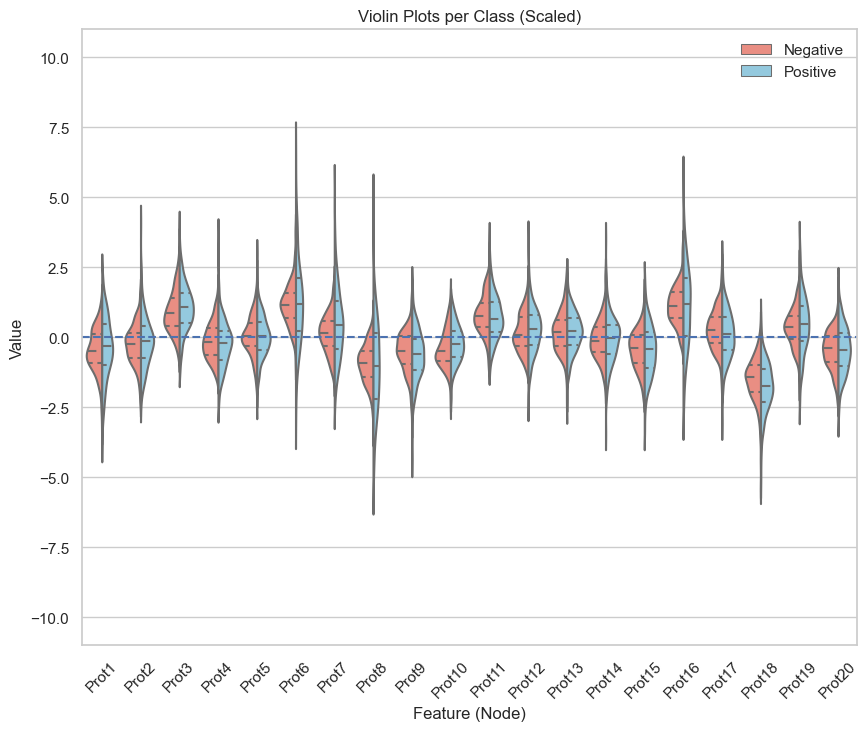

In [48]:
# Train standard scaler on training and validation data, then apply to test data
SCALE_DATA = True # Scale or use raw features

if SCALE_DATA:
    scaler = StandardScaler()
    # train the scaler on training and validation
    scaler.fit(np.concatenate((x_train, x_val), axis=0).reshape(-1, x_val.shape[-1])) 
    # apply the scaler to the data (prevent information leak to the test data)
    x_train = scaler.transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
    x_val = scaler.transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
    X_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

    # check the distribution
    data_scaled = np.hstack((
                            np.concatenate((x_train, x_val, x_test), axis=0).squeeze(), 
                            np.concatenate((y_train, y_val, y_test))
                            )
                        )
    df = pd.DataFrame(data=data_scaled, columns=list(data.columns[3:]) + [data.columns[2]]) # set the columns in the cirrect order
    df_melted1 = pd.melt(df, id_vars=['class'], 
                        value_vars=[f'Prot{i}' for i in range(1, 21)], 
                        var_name='Protein', value_name='Expression')
                                                                                                                                                                                                                                                                                                                                                                                                    
    sns.set(style="whitegrid")
    palette = {1: 'skyblue', 0: 'salmon'}
    plt.figure(figsize=(10, 8))
    ax = sns.violinplot(x='Protein', y='Expression', hue='class', data=df_melted1, split=True, inner="quart", palette=palette)
    ax.legend(handles=ax.legend_.legendHandles, labels=['Negative', 'Positive'])
    plt.axhline(y=0, color='b', linestyle='--')
    plt.title('Violin Plots per Class (Scaled)')
    plt.xlabel('Feature (Node)')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.ylim([-11, 11])
    plt.show()

## MLP
As a baseline model, we can firs us a classic MLP architecture, which completely ignores any topology of the dataset.

In [49]:

class Dataset_MLP():
    def __init__(self) -> None:
        self.x_train = torch.tensor(x_train.squeeze(), dtype=torch.float32).to(device)
        self.y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
        self.x_val = torch.tensor(x_val.squeeze(), dtype=torch.float32).to(device)
        self.y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
        self.x_test = torch.tensor(x_test.squeeze(), dtype=torch.float32).to(device)
        self.y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    
    def shuffle(self):
        self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
        self.x_val, self.y_val = shuffle(self.x_val, self.y_val)
        self.x_test, self.y_test = shuffle(self.x_test, self.y_test)

data_mlp = Dataset_MLP()

In [50]:
def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

In [51]:
# Create MLP mode
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return torch.sigmoid(x)

    def fit(self, data, epochs, verbose=False):
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1): 
            data.shuffle() # shuffle data 
            
            optimizer.zero_grad()
            out_train = self(data.x_train)
            
            loss = criterion(out_train, data.y_train)
            acc = accuracy(out_train>=0.5, data.y_train)
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0) and verbose:
                with torch.no_grad():
                    out_val = self(data.x_val)
                    val_loss = criterion(out_val, data.y_val)
                    val_acc = accuracy(out_val>=0.5, data.y_val)
                    print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                        f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                        f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()      
    def test(self, data):
        self.eval()
        out = self(data.x_test)
        acc = accuracy(out>=0.5, data.y_test)
        return acc

In [52]:
N_sim = 20 # number of you simulate to get the average performance
verbose = False
res_mlp = []
for i in range(N_sim):
    # Create MLP model
    mlp = MLP(dim_in=N, dim_h=16).to(device)
    # Train
    mlp.fit(data_mlp, epochs=150, verbose=verbose)
    # Test
    acc = mlp.test(data_mlp)
    if verbose:
        print(f'MLP test accuracy: {acc*100:.2f}%')
    
    # Store the results
    res_mlp.append(acc.detach().detach().cpu().numpy())

res_mlp = np.array(res_mlp)
print(f'\nMLP final accuracy: {np.mean(res_mlp)*100:.2f}%, std: {np.std(res_mlp)*100:.2f}%')


MLP final accuracy: 90.40%, std: 4.95%


### Prepare a graph dataset

In [53]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from scipy.sparse import coo_matrix

def get_data(dataset, idx):
    return list(map(dataset.__getitem__, idx))

dataset = []
for idx in range(len(A)):
    edge_index = coo_matrix(A[idx])
    sample = Data(x=x[idx], edge_index=np.vstack((edge_index.row, edge_index.col)), edge_weight=edge_index.data, y=y[idx])
    dataset.append(sample)

train_dataset = get_data(dataset, id_train) 
val_dataset = get_data(dataset, id_val) 
test_dataset = get_data(dataset, id_test) 

print(f"Number of samples: Training {len(train_dataset)} | Validation {len(val_dataset)} | Testing {len(test_dataset)}")   

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Number of samples: Training 350 | Validation 75 | Testing 75


### Vanilla GNN

In [54]:
# TODO 1. Normalize links 2. Try node embeddings 3. Convert data for MLP to pytorch dataset

### GCN